In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow
from sklearn import preprocessing

from keras.layers import Input ,Dense,Activation, Conv2D,AveragePooling2D,Flatten, Dropout, BatchNormalization, DepthwiseConv2D, SpatialDropout2D, SeparableConv2D
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.constraints import max_norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Work/Ahmadi roshan/data.csv", header=None)

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,9590,9591,9592,9593,9594,9595,9596,9597,9598,9599
0,4191.794611,4196.412151,4186.156133,4190.773112,4193.849301,4180.507537,4181.535427,4188.202593,4191.795611,4184.610940,...,4181.539306,4171.793575,4175.384269,4185.125222,4191.796289,4181.535557,4188.716384,4197.954986,4177.944303,0
1,4182.559268,4186.150262,4181.541344,4184.615203,4189.231349,4192.819404,4196.409071,4183.078691,4189.227592,4184.610940,...,4172.305406,4186.667219,4167.689847,4162.562185,4169.233598,4151.797628,4184.096281,4154.875525,4169.740869,0
2,4155.891485,4154.354969,4156.923634,4156.921481,4165.125638,4170.250538,4176.925367,4162.565945,4169.741333,4158.976251,...,3957.940196,3943.582777,3945.648367,3976.413093,3966.160694,3959.483779,3973.845177,3973.847147,3978.456186,0
3,4179.997152,4182.561361,4169.744326,4177.951164,4182.052532,4170.250538,4185.127681,4183.078691,4169.232575,4165.640923,...,4167.692791,4170.767216,4157.433474,4170.766926,4169.745597,4169.228594,4196.403071,4154.875525,4155.894261,0
4,4195.378225,4197.437552,4185.636040,4190.258547,4187.182657,4200.509985,4177.438546,4189.744905,4203.077130,4187.691615,...,4162.048407,4153.336229,4177.946220,4187.176407,4171.281596,4176.926295,4198.458248,4189.236428,4169.225788,0


In [ ]:
def divide_to_images(data_numpy_array):
  temp_dataset = data_numpy_array.reshape(-1, 640, 15)
  number_of_images = len(temp_dataset)
  dataset = np.zeros(shape = [number_of_images, 15, 640])
  for i in range(len(dataset)):
    dataset[i] = temp_dataset[i].transpose()
  return dataset

dataset = divide_to_images(data.to_numpy())    

In [ ]:
labels = pd.read_csv("/content/drive/MyDrive/Work/Ahmadi roshan/label.csv", header=None).to_numpy()
print(labels.shape)

(1375, 1)


# Scaling the dataset

In [ ]:
def apply_reference(dataset, reference_num = 14):
  temp_dataset = np.zeros((dataset.shape[0], dataset.shape[1]-1, dataset.shape[2]))
  for table_num, data in enumerate(dataset):
    dataset[table_num] = dataset[table_num] - dataset[table_num, reference_num, :]
    temp_dataset[table_num] = np.delete(dataset[table_num], reference_num, axis = 0)
  return temp_dataset
dataset = apply_reference(dataset)

In [ ]:
dataset.shape

(1375, 14, 640)

In [ ]:
def windowing(dataset, labels, length = 2, intersect = 1, data_freq=128):
  data_segmented = []
  labels_segmented = []
  data_time = dataset.shape[2] / data_freq
  step = (length - intersect)* data_freq
  window_length = length* data_freq
  if data_time < length:
    return dataset, labels
  for ind, data in enumerate(dataset):
    start_pointer = 0
    end_pointer = window_length
    while end_pointer < dataset.shape[2]:
      temp_data = dataset[ind, :, start_pointer : end_pointer]
      temp_label = labels[ind, 0]
      data_segmented.append(temp_data)
      labels_segmented.append(temp_label)
      start_pointer = start_pointer + step
      end_pointer = start_pointer + window_length
  data_segmented = np.array(data_segmented)
  labels_segmented = np.array(labels_segmented).reshape(-1,1)
  return data_segmented, labels_segmented

augmented_dataset, augmented_labels = windowing(dataset, labels)


In [ ]:
np.unique(augmented_labels)


array([1, 2, 3, 4, 5])

In [ ]:
augmented_dataset = (augmented_dataset - augmented_dataset.mean()) / augmented_dataset.std()

In [ ]:
augmented_labels = to_categorical(augmented_labels-1)
augmented_labels.shape

(4125, 5)

# Let's Implement our Model!

In [ ]:
def build_model(input_shape):
  
  x_input = Input(shape =input_shape,name = 'input')

  x = Conv2D(filters = 16,kernel_size = (2,2), strides = 2, padding = 'valid',name = 'conv1')(x_input)
  x = Activation('relu')(x)
  x = AveragePooling2D(pool_size =2,strides = 2,name = 'pad1')(x)

  x = Conv2D(filters = 16,kernel_size = (2,2), strides = 1, padding = 'valid',name = 'conv2')(x)
  x = Activation('relu')(x)
  x = AveragePooling2D(pool_size =2,strides = 2,name = 'pad2')(x)

  x = Flatten()(x)

  x = Dense(units = 120, name = 'fc_1')(x)

  x = Activation('relu', name = 'relue')(x)
  # x = Dropout(rate = 0.5)

  x = Dense(units = 84, name = 'fc_2')(x)
  x = Activation('relu', name = 'relu_3')(x)
  # x = Dropout(rate = 0.5)


  outputs = Dense(units = 5,name = 'softmax', activation='softmax')(x)
  
  model = Model(inputs = x_input, outputs = outputs)
  model.summary()

  return model

In [ ]:
def EEGNet_SSVEP(nb_classes = 12, Chans = 8, Samples = 256, 
             dropoutRate = 0.5, kernLength = 256, F1 = 96, 
             D = 1, F2 = 96, dropoutType = 'Dropout'):
    """ SSVEP Variant of EEGNet, as used in [1]. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. 
      D               : number of spatial filters to learn within each temporal
                        convolution.
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
      
      
    [1]. Waytowich, N. et. al. (2018). Compact Convolutional Neural Networks
    for Classification of Asynchronous Steady-State Visual Evoked Potentials.
    Journal of Neural Engineering vol. 15(6). 
    http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

# Dividing Our Dataset To train and test set.

In [ ]:
train_x, test_x, train_y, test_y  = train_test_split(augmented_dataset, augmented_labels , test_size=0.05, shuffle=True, random_state=5)

In [ ]:
train_x.shape

(3918, 14, 256)

In [ ]:
test_x.shape

(207, 14, 256)

In [ ]:
dataset.shape

(1375, 14, 640)

In [ ]:
# model = build_model((14, 256,1))
model = EEGNet_SSVEP(5, 14, 256, kernLength=256)
model.compile(optimizer ='adam',loss = 'categorical_crossentropy' ,metrics = ['accuracy'])

In [ ]:
model.fit(x = train_x, y= train_y , epochs = 300, validation_data=(test_x, test_y))

Epoch 1/300
123/123 [==============================] - 2s 14ms/step - loss: 0.9379 - accuracy: 0.6478 - val_loss: 1.3534 - val_accuracy: 0.5556
Epoch 2/300
123/123 [==============================] - 2s 13ms/step - loss: 0.9782 - accuracy: 0.6276 - val_loss: 1.3816 - val_accuracy: 0.4928
Epoch 3/300
123/123 [==============================] - 2s 13ms/step - loss: 0.9526 - accuracy: 0.6440 - val_loss: 1.4683 - val_accuracy: 0.5072
Epoch 4/300
123/123 [==============================] - 2s 13ms/step - loss: 0.9269 - accuracy: 0.6445 - val_loss: 1.5036 - val_accuracy: 0.4058
Epoch 5/300
123/123 [==============================] - 2s 14ms/step - loss: 0.9618 - accuracy: 0.6289 - val_loss: 1.4312 - val_accuracy: 0.5024
Epoch 6/300
123/123 [==============================] - 2s 13ms/step - loss: 0.9377 - accuracy: 0.6437 - val_loss: 1.3477 - val_accuracy: 0.5507
Epoch 7/300
123/123 [==============================] - 2s 13ms/step - loss: 0.9396 - accuracy: 0.6399 - val_loss: 1.3438 - val_accuracy:

In [ ]:
predictions = model.predict(test_x)
pred_labels = np.argmax(predictions, axis = 1).reshape(-1)
test_labels = np.argmax(test_y, axis =1).reshape(-1)

In [ ]:
print("the final accuracy: ",np.count_nonzero(pred_labels == test_labels)/test_labels.shape[0])

the final accuracy:  0.5603864734299517


In [ ]:
model.save('model.h5')

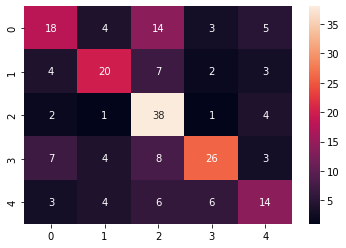

In [ ]:
cf_mat = confusion_matrix(test_labels, pred_labels)
sns.heatmap(cf_mat, annot=True)